In [ ]:
!pip install -r requirements.txt

In [71]:
import pandas as pd
import torch
import torch.nn.functional as F
import datasets
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
import matplotlib.pyplot as plt
import numpy as np

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_name = 'gpt2-xl'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

In [5]:
# implementing "greedy search decoding" manually

input_txt = 'Transformers are the'
input_ids = tokenizer(input_txt, return_tensors='pt')['input_ids'].to(device)
iterations = []
n_steps = 8
choices_per_step = 5

with torch.inference_mode():
    for step in range(n_steps):
        iteration = dict()
        iteration['Input'] = tokenizer.decode(input_ids[0]) # grab the first item to avoid error
        output = model(input_ids=input_ids) # predict input's and next token's logits
        next_token_logits = output.logits[0, -1, :] # next token's logits
        next_token_probs = torch.softmax(next_token_logits, dim=-1) # convert logits to softmax
        sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True)
        for choice_idx in range(choices_per_step):
            token_id = sorted_ids[choice_idx]
            token_prob = next_token_probs[token_id].cpu().numpy()
            token_choice = f"{tokenizer.decode(token_id)} ({token_prob:.2f})%"
            iteration[f'Choice {choice_idx+1}'] = token_choice
        input_ids = torch.cat([input_ids, sorted_ids[None, None, 0]], dim=-1)
        
        iterations.append(iteration)
        
display(pd.DataFrame(iterations))

,Input,Choice 1,Choice 2,Choice 3,Choice 4,Choice 5
0,Transformers are the,most (0.09)%,only (0.05)%,best (0.05)%,Transformers (0.04)%,ultimate (0.02)%
1,Transformers are the most,popular (0.17)%,powerful (0.05)%,common (0.05)%,famous (0.04)%,successful (0.03)%
2,Transformers are the most popular,toy (0.11)%,toys (0.07)%,Transformers (0.07)%,of (0.05)%,and (0.04)%
3,Transformers are the most popular toy,line (0.34)%,in (0.18)%,of (0.12)%,brand (0.06)%,line (0.03)%
4,Transformers are the most popular toy line,in (0.46)%,of (0.15)%,", (0.05)%",on (0.04)%,ever (0.03)%
5,Transformers are the most popular toy line in,the (0.66)%,history (0.12)%,America (0.07)%,Japan (0.02)%,North (0.01)%
6,Transformers are the most popular toy line in the,world (0.69)%,United (0.05)%,history (0.04)%,US (0.04)%,U (0.02)%
7,Transformers are the most popular toy line in ...,", (0.40)%",. (0.31)%,and (0.10)%,with (0.02)%,today (0.02)%


In [11]:
# using "greedy search decoding" using the built-in method

input_ids = tokenizer(input_txt, return_tensors='pt')['input_ids'].to(device)
output = model.generate(input_ids, max_new_tokens=n_steps, do_sample=False)
tokenizer.decode(output[0])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'Transformers are the most popular toy line in the world,'

In [65]:
max_length = 128
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""

input_ids = tokenizer(input_txt, return_tensors='pt')['input_ids'].to(device)
output_greedy = model.generate(input_ids, max_length=max_length, do_sample=False)

print(tokenizer.decode(output_greedy[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The researchers, from the University of California, Davis, and the University of Colorado, Boulder, were conducting a study on the Andean cloud forest, which is home to the rare species of cloud forest trees.


The researchers were surprised to find that the unicorns were able to communicate with each other, and even with humans.


The researchers were surprised to find that the unicorns were able


In [62]:
def log_probs_from_logits(logits, labels):
    logp = F.log_softmax(logits, dim=-1)
    logp_label = torch.gather(logp, dim=-1, index=labels.unsqueeze(-1)).squeeze(-1)

    return logp_label

In [64]:
def sequence_logprob(model, labels, input_len=0):
    with torch.inference_mode():
        output = model(labels)
    log_probs = log_probs_from_logits(output.logits[:, :-1, :], labels[:, 1:])
    seq_log_prob = torch.sum(log_probs[:, input_len:])

    return seq_log_prob.cpu().numpy()

In [66]:
logp = sequence_logprob(model, output_greedy, input_len=len(input_ids[0]))

print(tokenizer.decode(output_greedy[0]))
print(f"\nSequence Log-Prob: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The researchers, from the University of California, Davis, and the University of Colorado, Boulder, were conducting a study on the Andean cloud forest, which is home to the rare species of cloud forest trees.


The researchers were surprised to find that the unicorns were able to communicate with each other, and even with humans.


The researchers were surprised to find that the unicorns were able

Sequence Log-Prob: -87.43


"Beam Search" can be seen as a more sophisticated decoding strategy than "Greedy Search".
Contrary to greedy search, beam search keeps track of the top-b most probable tokens, where b is referred to as the number of beams or partial hypothesis. The next set of beams are chosen by considering the all possible next token extentions of the existing set and selecting the b most likely extenstions.
The output sequence is the beam (i.e. a branch) with the highest log probability, given by the sum of log probability of the predicted tokens.

Beam Search with n-gram penalty is a good trade-off between focusing on high-probability tokens while reducing repetitions.

In [68]:
output_beam = model.generate(input_ids, max_length=max_length, do_sample=False, num_beams=5)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))

print(tokenizer.decode(output_beam[0]))
print(f"\n Sequence Log-Prob: {logp:.2f}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The discovery of the unicorns was made by a team of scientists from the University of California, Santa Cruz, and the National Geographic Society.


The scientists were conducting a study of the Andes Mountains when they discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English

 Sequence Log-Prob: -55.23


In [70]:
output_beam = model.generate(
    input_ids,
    max_length=max_length,
    do_sample=False,
    num_beams=5,
    no_repeat_ngram_size=2
)

logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\n Sequence Log-Prob: {logp:.2f}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The discovery was made by a team of scientists from the University of California, Santa Cruz, and the National Geographic Society.

According to a press release, the scientists were conducting a survey of the area when they came across the herd. They were surprised to find that they were able to converse with the animals in English, even though they had never seen a unicorn in person before. The researchers were

 Sequence Log-Prob: -93.12


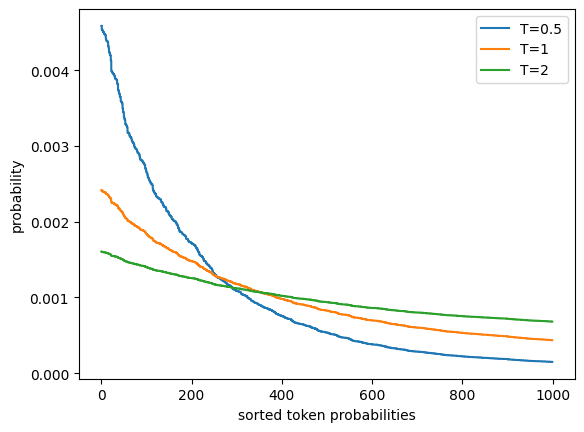

In [75]:
def softmax(logits, T=1):
    e_x = np.exp(logits / T)
    return e_x / e_x.sum()

logits = np.exp(np.random.random(1000))
sorted_logits = np.sort(logits)[::-1]
x = np.arange(1000)

for T in [0.5, 1, 2]:
    plt.step(x, softmax(sorted_logits, T), label=f"T={T}")
plt.legend(loc='best')
plt.xlabel("sorted token probabilities")
plt.ylabel("probability")
plt.show()